## Imports et Configuration

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
from PIL import Image
import time
import os
import copy

# Configuration
CONFIG = {
    'img_size': 64,          # Taille réduite pour Edge AI
    'embed_dim': 128,        # Taille vecteur latent z
    'num_classes': 3,        # 0: Alert, 1: Drowsy, 2: Distracted
    'recursion_depth': 4,    # Nombre d'itérations du TRM (n)
    'batch_size': 32,
    'lr': 1e-3,
    'epochs': 200,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_path': 'best_trm_model.pth'
}

print(f"Utilisation du device : {CONFIG['device']}")

Utilisation du device : cuda


### Architecture TRM (Tiny Recursive Model)

In [8]:
# Spatial TRM + Attention

class SpatialVisualEmbedding(nn.Module):
    """
    Encodeur qui conserve la dimension spatiale (4x4 patches) 
    au lieu de tout aplatir. Permet l'attention.
    """
    def __init__(self, output_dim):
        super().__init__()
        self.features = nn.Sequential(
            # Étape 1 : 64x64 -> 32x32 (Sortie 32 canaux)
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            
            # Étape 2 : 32x32 -> 16x16 (Sortie 64 canaux)
            # CORRECTION ICI : Entrée 32 canaux (pas 3)
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU6(),
            
            # Étape 3 : 16x16 -> 8x8 (Sortie output_dim canaux)
            nn.Conv2d(64, output_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(output_dim),
            nn.ReLU6(),
            
            # Force une grille de 4x4 (16 tokens) peu importe la taille d'entrée
            nn.AdaptiveAvgPool2d((4, 4)) 
        )
    
    def forward(self, x):
        # Sortie: [Batch, Dim, 4, 4] -> Flatten -> [Batch, Dim, 16] -> Permute -> [Batch, 16, Dim]
        x = self.features(x)
        B, C, H, W = x.shape
        x = x.view(B, C, -1).permute(0, 2, 1) 
        return x

class AttentionTRMBlock(nn.Module):
    """
    Bloc récursif utilisant le Self-Attention (Transformer).
    C'est ici que le modèle gagne en précision en reliant les détails (yeux, bouche, mains).
    """
    def __init__(self, embed_dim, num_classes, num_heads=4):
        super().__init__()
        # Couche d'attention
        self.attn_norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=num_heads, batch_first=True)
        
        # Réseau Feed-Forward
        self.ffn_norm = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        
        # Tête de classification (Moyenne des patches)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x_feat, z_prev):
        # 1. Fusion de l'Input visuel et du Raisonnement précédent
        z_curr = z_prev + x_feat
        
        # 2. Self-Attention : Le modèle compare les patches entre eux
        z_norm = self.attn_norm(z_curr)
        attn_out, _ = self.attn(z_norm, z_norm, z_norm)
        z_curr = z_curr + attn_out # Connexion résiduelle
        
        # 3. Feed-Forward
        z_curr = z_curr + self.ffn(self.ffn_norm(z_curr))
        
        # 4. Prédiction : On fait la moyenne des 16 patches pour décider
        z_pooled = z_curr.mean(dim=1) 
        y_logits = self.head(z_pooled)
        
        return z_curr, y_logits

class DriverTRM(nn.Module):
    """
    Classe principale mise à jour pour utiliser l'Attention.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Utilisation des nouveaux blocs définis ci-dessus
        self.embedding = SpatialVisualEmbedding(config['embed_dim'])
        self.trm_block = AttentionTRMBlock(config['embed_dim'], config['num_classes'])
        
    def forward(self, img):
        # x_feat est maintenant une séquence : [Batch, 16, Dim]
        x_feat = self.embedding(img)
        
        # z_curr est aussi une séquence (mémoire spatiale)
        z_curr = torch.zeros_like(x_feat).to(img.device)
        
        outputs_list = []
        
        # Boucle de Raisonnement Récursif
        for _ in range(self.config['recursion_depth']):
            z_curr, y_logits = self.trm_block(x_feat, z_curr)
            outputs_list.append(y_logits)
            
        return outputs_list

### Téléchargement et Préparation des Données

In [9]:
import kagglehub
import os
import glob
from pathlib import Path

def download_and_prepare_data():
    print("--- Téléchargement des Datasets via KaggleHub ---")
    
    # 1. Télécharger Eye Dataset (Somnolence)
    eye_path = kagglehub.dataset_download("coderkr/eye-dataset")
    print(f"Eye Dataset téléchargé dans : {eye_path}")
    
    # 2. Télécharger State Farm (Distraction)
    sf_path = kagglehub.dataset_download("rightway11/state-farm-distracted-driver-detection")
    print(f"State Farm Dataset téléchargé dans : {sf_path}")
    
    # Listes pour stocker les chemins et les labels
    # 0: Alert, 1: Drowsy, 2: Distracted
    all_image_paths = []
    all_labels = []
    
    print("\n--- Indexation des images State Farm (Distraction) ---")
    # Structure attendue : sf_path/imgs/train/c0...c9
    # c0 = Safe driving -> Label 0
    # c1-c9 = Distracted -> Label 2
    sf_train_dir = os.path.join(sf_path, 'imgs', 'train')
    
    if os.path.exists(sf_train_dir):
        for class_folder in os.listdir(sf_train_dir):
            class_path = os.path.join(sf_train_dir, class_folder)
            if os.path.isdir(class_path):
                # Déterminer le label
                label = 0 if class_folder == 'c0' else 2
                
                # Récupérer les images jpg
                images = glob.glob(os.path.join(class_path, '*.jpg'))
                all_image_paths.extend(images)
                all_labels.extend([label] * len(images))
                print(f"Classe {class_folder} -> Label {label} ({len(images)} images)")
    else:
        print(f"ERREUR: Dossier train introuvable dans {sf_train_dir}")

    print("\n--- Indexation des images Eye Dataset (Somnolence) ---")
    # Structure typique coderkr : /train/Open_Eyes et /train/Closed_Eyes
    # Open -> Label 0 (Renforce la classe Alert)
    # Closed -> Label 1 (Drowsy)
    
    # Recherche récursive des dossiers Open/Closed car la structure peut varier
    for root, dirs, files in os.walk(eye_path):
        for dir_name in dirs:
            lower_name = dir_name.lower()
            label = None
            
            if 'open' in lower_name:
                label = 0
            elif 'closed' in lower_name:
                label = 1
            
            if label is not None:
                folder_path = os.path.join(root, dir_name)
                images = glob.glob(os.path.join(folder_path, '*.*')) # jpg, png
                # Filtrer pour ne garder que les images
                images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                all_image_paths.extend(images)
                all_labels.extend([label] * len(images))
                print(f"Dossier {dir_name} -> Label {label} ({len(images)} images)")

    print(f"\nTotal images indexées : {len(all_image_paths)}")
    return all_image_paths, all_labels

# Exécution
image_paths, labels = download_and_prepare_data()

--- Téléchargement des Datasets via KaggleHub ---
Eye Dataset téléchargé dans : C:\Users\anase\.cache\kagglehub\datasets\coderkr\eye-dataset\versions\1
State Farm Dataset téléchargé dans : C:\Users\anase\.cache\kagglehub\datasets\rightway11\state-farm-distracted-driver-detection\versions\1

--- Indexation des images State Farm (Distraction) ---
Classe c0 -> Label 0 (1953 images)
Classe c1 -> Label 2 (1754 images)
Classe c2 -> Label 2 (1783 images)
Classe c3 -> Label 2 (1809 images)
Classe c4 -> Label 2 (1817 images)
Classe c5 -> Label 2 (1804 images)
Classe c6 -> Label 2 (1811 images)
Classe c7 -> Label 2 (1532 images)
Classe c8 -> Label 2 (1518 images)
Classe c9 -> Label 2 (1681 images)

--- Indexation des images Eye Dataset (Somnolence) ---

Total images indexées : 17462


### Le Dataset PyTorch Réel (Fusionné)

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T

class RealDriverDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Chargement de l'image (RGB)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
                
            return img, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            # Gestion basique des erreurs (fichier corrompu)
            print(f"Erreur chargement {img_path}: {e}")
            # Retourner une image noire factice pour ne pas planter le batch
            return torch.zeros((3, 64, 64)), torch.tensor(label, dtype=torch.long)

# --- Configuration des Transformations (Data Augmentation) ---
# Essentiel pour homogénéiser State Farm (Corps entier) et Eye Dataset (Gros plan)
def get_transforms(phase='train'):
    if phase == 'train':
        return T.Compose([
            T.Resize((64, 64)), # Taille d'entrée du TRM
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(10),
            # Simulation conditions nuit/tunnel
            T.ColorJitter(brightness=0.3, contrast=0.3), 
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return T.Compose([
            T.Resize((64, 64)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

### Création des DataLoaders avec les Vraies Données

In [11]:
# 1. Instanciation du Dataset complet avec les données téléchargées plus haut
# image_paths et labels proviennent de votre fonction download_and_prepare_data()
full_dataset = RealDriverDataset(
    image_paths, 
    labels, 
    transform=get_transforms('train') # On applique les augmentations (rotation, bruit, etc.)
)

print(f"Dataset créé avec {len(full_dataset)} images.")

# 2. Division Train / Validation (80% Train, 20% Val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# generator=torch.Generator().manual_seed(42) assure que le split est toujours le même
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Images d'entraînement : {len(train_ds)}")
print(f"Images de validation : {len(val_ds)}")

# 3. Création des DataLoaders (Ce sont eux que 'train_model' va appeler)
# num_workers > 0 permet de charger les images en parallèle pour ne pas ralentir le GPU
# pin_memory=True accélère le transfert vers le GPU (cuda)
train_loader = DataLoader(
    train_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

print("DataLoaders prêts !")

Dataset créé avec 17462 images.
Images d'entraînement : 13969
Images de validation : 3493
DataLoaders prêts !


### Boucle d'Entraînement avec Deep Supervision & Checkpointing

In [13]:
# Entropy + Scheduler

import torch.optim as optim
import time
from sklearn.metrics import f1_score

# Fonction pour calculer l'Entropie (Incertitude)
def calculate_entropy(probs):
    """
    Plus l'entropie est basse (proche de 0), plus le modèle est sûr de lui.
    """
    epsilon = 1e-8
    entropy = -torch.sum(probs * torch.log(probs + epsilon), dim=1)
    return entropy.mean().item()

# Fonction de perte Deep Supervision
def deep_supervision_loss(outputs_list, targets, criterion):
    total_loss = 0
    for output in outputs_list:
        total_loss += criterion(output, targets)
    return total_loss / len(outputs_list)

def train_model():
    print(f"🚀 Démarrage de l'entraînement avec Attention sur {CONFIG['device']}...")
    
    # Instanciation du nouveau modèle
    model = DriverTRM(CONFIG).to(CONFIG['device'])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    criterion = nn.CrossEntropyLoss()
    
    # Scheduler : Divise le Learning Rate par 2 si la précision stagne pendant 5 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # Ajout de 'val_entropy' à l'historique
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_entropy': []}
    
    best_val_f1 = 0.0
    start_time = time.time()

    print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Val Loss':^8} | {'Val Acc':^8} | {'Val F1':^8} | {'Entropy':^7} | {'LR':^7}")
    print("-" * 85)

    for epoch in range(CONFIG['epochs']):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
            optimizer.zero_grad()
            
            # Forward
            outputs_list = model(imgs)
            
            # Loss sur toutes les étapes
            loss = deep_supervision_loss(outputs_list, labels, criterion)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        
        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_entropy_sum = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
                
                outputs_list = model(imgs)
                
                loss = deep_supervision_loss(outputs_list, labels, criterion)
                val_loss += loss.item()
                
                # Métriques sur la dernière sortie
                final_logits = outputs_list[-1]
                probs = F.softmax(final_logits, dim=1)
                
                # Calcul de l'entropie
                val_entropy_sum += calculate_entropy(probs)
                
                preds = torch.argmax(final_logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_entropy = val_entropy_sum / len(val_loader)
        val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Mise à jour du Scheduler
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Historique
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_entropy'].append(avg_val_entropy)
        
        # Checkpointing
        save_msg = ""
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), CONFIG['save_path'])
            save_msg = "--> Saved!"
            
        print(f"{epoch+1:^7} | {avg_train_loss:^10.4f} | {avg_val_loss:^8.4f} | {val_acc:^8.4f} | {val_f1:^8.4f} | {avg_val_entropy:^7.4f} | {current_lr:.1e} {save_msg}")

    print("\nEntraînement terminé.")
    return model, history, all_labels, all_preds

# Lancement de l'entraînement
trained_model, history, y_true, y_pred = train_model()

🚀 Démarrage de l'entraînement avec Attention sur cuda...
 Epoch  | Train Loss | Val Loss | Val Acc  |  Val F1  | Entropy |   LR   
-------------------------------------------------------------------------------------
   1    |   0.3330   |  0.2957  |  0.9047  |  0.8885  | 0.3736  | 1.0e-03 --> Saved!
   2    |   0.2435   |  0.2400  |  0.9153  |  0.9163  | 0.3182  | 1.0e-03 --> Saved!
   3    |   0.1829   |  0.2886  |  0.9001  |  0.8645  | 0.0576  | 1.0e-03 
   4    |   0.1481   |  0.1541  |  0.9456  |  0.9391  | 0.0796  | 1.0e-03 --> Saved!
   5    |   0.1246   |  0.1246  |  0.9496  |  0.9512  | 0.1651  | 1.0e-03 --> Saved!
   6    |   0.1120   |  0.1001  |  0.9674  |  0.9679  | 0.1027  | 1.0e-03 --> Saved!
   7    |   0.0930   |  0.1175  |  0.9513  |  0.9469  | 0.1171  | 1.0e-03 
   8    |   0.0857   |  0.0844  |  0.9688  |  0.9689  | 0.0876  | 1.0e-03 --> Saved!
   9    |   0.0805   |  0.0884  |  0.9682  |  0.9668  | 0.0634  | 1.0e-03 
  10    |   0.0755   |  0.0586  |  0.9814  |  0.

### Affichage des Résultats et Plots

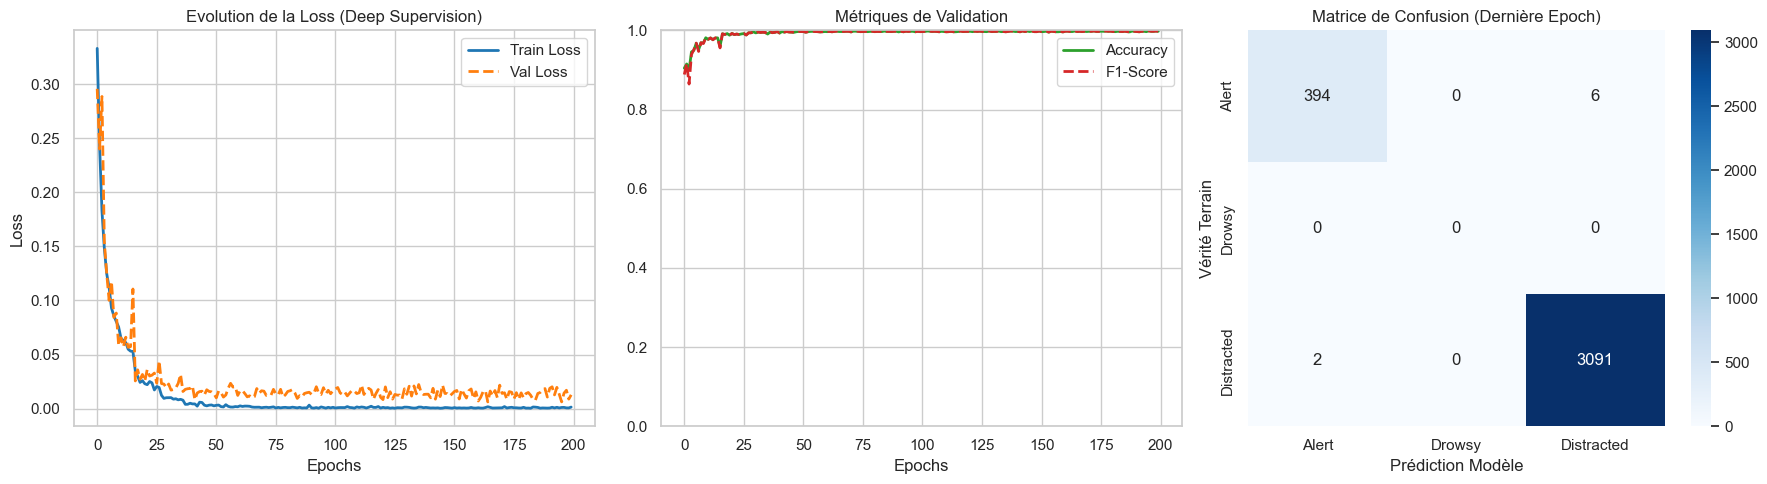


--- Rapport de Classification ---
              precision    recall  f1-score   support

       Alert       0.99      0.98      0.99       400
      Drowsy       0.00      0.00      0.00         0
  Distracted       1.00      1.00      1.00      3093

    accuracy                           1.00      3493
   macro avg       0.66      0.66      0.66      3493
weighted avg       1.00      1.00      1.00      3493



In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_results(history, y_true, y_pred, classes=['Alert', 'Drowsy', 'Distracted']):
    # CORRECTION : On force la liste des labels attendus [0, 1, 2]
    # Cela évite le crash si une classe est manquante dans les prédictions
    all_labels = range(len(classes)) 

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Courbes de Loss 
    ax[0].plot(history['train_loss'], label='Train Loss', color='tab:blue', linewidth=2)
    ax[0].plot(history['val_loss'], label='Val Loss', color='tab:orange', linewidth=2, linestyle='--')
    ax[0].set_title("Evolution de la Loss (Deep Supervision)")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    # 2. Courbes de Métriques (Accuracy & F1)
    ax[1].plot(history['val_acc'], label='Accuracy', color='tab:green', linewidth=2)
    ax[1].plot(history['val_f1'], label='F1-Score', color='tab:red', linewidth=2, linestyle='--')
    ax[1].set_title("Métriques de Validation")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylim(0, 1.0)
    ax[1].legend()
    
    # 3. Matrice de Confusion 
    # AJOUT : paramètre 'labels' pour forcer la matrice 3x3 même si une classe manque
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2], 
                xticklabels=classes, yticklabels=classes)
    ax[2].set_title("Matrice de Confusion (Dernière Epoch)")
    ax[2].set_ylabel("Vérité Terrain")
    ax[2].set_xlabel("Prédiction Modèle")
    
    plt.tight_layout()
    plt.show()
    
    # Rapport textuel détaillé
    print("\n--- Rapport de Classification ---")
    # AJOUT : paramètres 'labels' et 'zero_division'
    print(classification_report(y_true, y_pred, target_names=classes, labels=all_labels, zero_division=0))

# Afficher les graphiques
plot_results(history, y_true, y_pred)

### Entropy

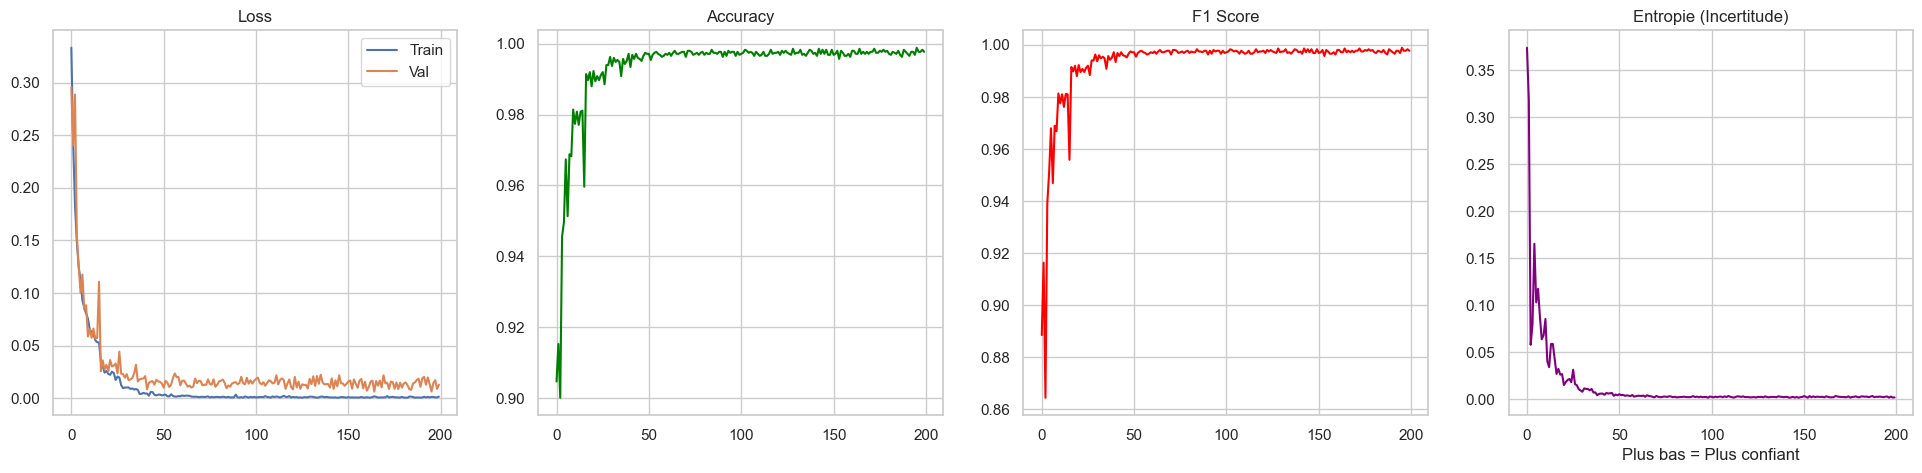

In [15]:
def plot_results_with_entropy(history):
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 4, figsize=(24, 5)) # 4 graphiques maintenant
    
    # 1. Loss
    ax[0].plot(history['train_loss'], label='Train')
    ax[0].plot(history['val_loss'], label='Val')
    ax[0].set_title("Loss")
    ax[0].legend()
    
    # 2. Accuracy
    ax[1].plot(history['val_acc'], color='green')
    ax[1].set_title("Accuracy")
    
    # 3. F1-Score
    ax[2].plot(history['val_f1'], color='red')
    ax[2].set_title("F1 Score")
    
    # 4. Entropy (Nouveau)
    ax[3].plot(history['val_entropy'], color='purple')
    ax[3].set_title("Entropie (Incertitude)")
    ax[3].set_xlabel("Plus bas = Plus confiant")
    
    plt.show()

plot_results_with_entropy(history)

### Chargement du meilleur modèle pour inférence

In [ ]:
def load_best_model():
    print(f"Chargement du meilleur modèle depuis : {CONFIG['save_path']}")
    
    # 1. Recréer l'architecture
    model = DriverTRM(CONFIG)
    
    # 2. Charger les poids
    model.load_state_dict(torch.load(CONFIG['save_path'], map_location=CONFIG['device']))
    model.to(CONFIG['device'])
    model.eval()
    
    print("Modèle chargé avec succès. Prêt pour l'inférence Edge.")
    return model

best_model = load_best_model()

Chargement du meilleur modèle depuis : best_trm_model.pth
Modèle chargé avec succès. Prêt pour l'inférence Edge.
